<h1>Classification Trees</h1>

```
Carseats.csv
A data frame containing observations on sales of child car seats at 400 different stores and the following 11 variables:

Sales        Unit sales (in thousands) at each location
CompPrice    Price charged by competitor at each location
Income       Community income level (in thousands of dollars)
Advertising  Local advertising budget for company at each location (in thousands of dollars)
Population   Population size in region (in thousands)
Price        Price company charges for car seats at each site
ShelveLoc    A factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each site
Age          Average age of the local population
Education    Education level at each location
Urban        A factor with levels No and Yes to indicate whether the store is in an urban or rural location
US           A factor with levels No and Yes to indicate whether the store is in the US or not
```

In [1]:
import pydot
from IPython.display import Image
from six import StringIO  
from sklearn.tree import export_graphviz

# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    (graph,) = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

In [2]:
import pandas as pd
df = pd.read_csv('https://r-data.pmagunia.com/system/files/datasets/dataset-11424.csv')
df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [3]:
# Pre-processing the data

df['High'] = df.Sales.map(lambda x: 1 if x>8 else 0)
df.ShelveLoc = pd.factorize(df.ShelveLoc)[0]
df.Urban = df.Urban.map({'No':0, 'Yes':1})
df.US = df.US.map({'No':0, 'Yes':1})
df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,0,42,17,1,1,1
1,11.22,111,48,16,260,83,1,65,10,1,1,1
2,10.06,113,35,10,269,80,2,59,12,1,1,1
3,7.40,117,100,4,466,97,2,55,14,1,1,0
4,4.15,141,64,3,340,128,0,38,13,1,0,0


In [4]:
X = df.drop(['Sales', 'High'], axis=1)
y = df.High

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

<h2>The Basics</h2>

A classification tree is very similar to a regression tree, except that it is used to predict a qualitative response rather than a quantitative one, i.e., we predict that each observation belongs to the <em>most commonly occurring class</em> of training
observations in the region to which it belongs.

The task of growing a classification tree is quite similar to the task of growing a regression tree. Just as in the regression setting, we use recursive binary splitting to grow a classification tree. However, in the classification setting, $RSS$ cannot be used as a criterion for making the binary splits.

<ins>__Option 1__</ins>: Classification Error Rate

Since we plan to assign an observation in a given region to the most commonly occurring error rate class of training observations in that region, the classification error rate is simply the fraction of the training observations in that region that do not belong to the most common class:

$$E=1-\max _{k}\left(\hat{p}_{m k}\right)$$

Here $\hat{p}_{m k}$ represents the proportion of training observations in the $m$th region that are from the $k$ th class.

In [5]:
def classification_error(p):
    return 1 - np.max([p, 1 - p])

<ins>__Option 2__</ins>: Gini Index

The Gini index is defined by
$$
G=\sum_{k=1}^{K} \hat{p}_{m k}\left(1-\hat{p}_{m k}\right)
$$
a measure of total variance across the $K$ classes. It is not hard to see that the Gini index takes on a small value if all of the $\hat{p}_{m k}$ 's are close to zero or one. For this reason the Gini index is referred to as a measure of node purity-a small value indicates that a node contains predominantly observations from a single class.

In [6]:
def gini(p):
    return 2*(p)*(1 - p)

<ins>__Option 3__</ins>: Cross-Entropy

$$
D=-\sum_{k=1}^{K} \hat{p}_{m k} \log \hat{p}_{m k}\left(\frac{1}{2\log(2)}\right)
$$

Since $0 \leq \hat{p}_{m k} \leq 1$, it follows that $0 \leq-\hat{p}_{m k} \log \hat{p}_{m k}$. One can show that the entropy will take on a value near zero if the $\hat{p}_{m k}$ 's are all near zero or near one. Therefore, like the Gini index, the entropy will take on a small value if the $m$ th node is pure.

👉🏼 In fact, it turns out that the Gini index and the entropy are quite similar numerically.

In [7]:
def entropy(p):
    return (p*np.log((1-p)/p) - np.log(1 - p)) / (2*np.log(2))

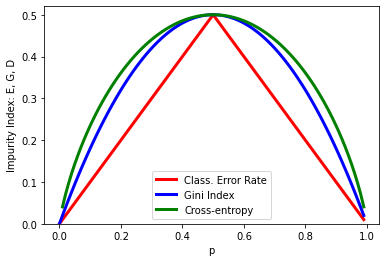

In [8]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0.0, 1.0, 0.01)
class_error_vals = [classification_error(i) for i in x]
gini_vals = gini(x)
entropy_vals = [entropy(i) if i != 0 else None for i in x]

fig = plt.figure()
ax = plt.subplot()

for j, lab, c, in zip(
    [class_error_vals, gini_vals, entropy_vals],
    ['Class. Error Rate', 'Gini Index', 'Cross-entropy'],
    ['red', 'blue', 'green']):
    line = ax.plot(x, j, label=lab, linestyle='-', lw=3, color=c)

ax.legend(loc='lower center', fancybox=True, shadow=False)

plt.ylim([0, 0.52])
plt.xlabel('p')
plt.ylabel('Impurity Index: E, G, D')
plt.show()

<h2>Example</h2>

The [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) from `sklearn` only options are the `gini` and the `entropy` impurity indexes:

In [9]:
from sklearn.tree import DecisionTreeClassifier
clf_gini = DecisionTreeClassifier(criterion='gini',max_depth=6)
clf_gini.fit(X_train, y_train)
clf_entropy = DecisionTreeClassifier(criterion='entropy',max_depth=6)
clf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [10]:
from sklearn.metrics import classification_report
print(classification_report(y_train, clf_gini.predict(X_train)))
print(classification_report(y_train, clf_entropy.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       118
           1       0.97      0.91      0.94        82

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.95       200
weighted avg       0.96      0.95      0.95       200

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       118
           1       0.99      0.80      0.89        82

    accuracy                           0.92       200
   macro avg       0.93      0.90      0.91       200
weighted avg       0.92      0.92      0.91       200



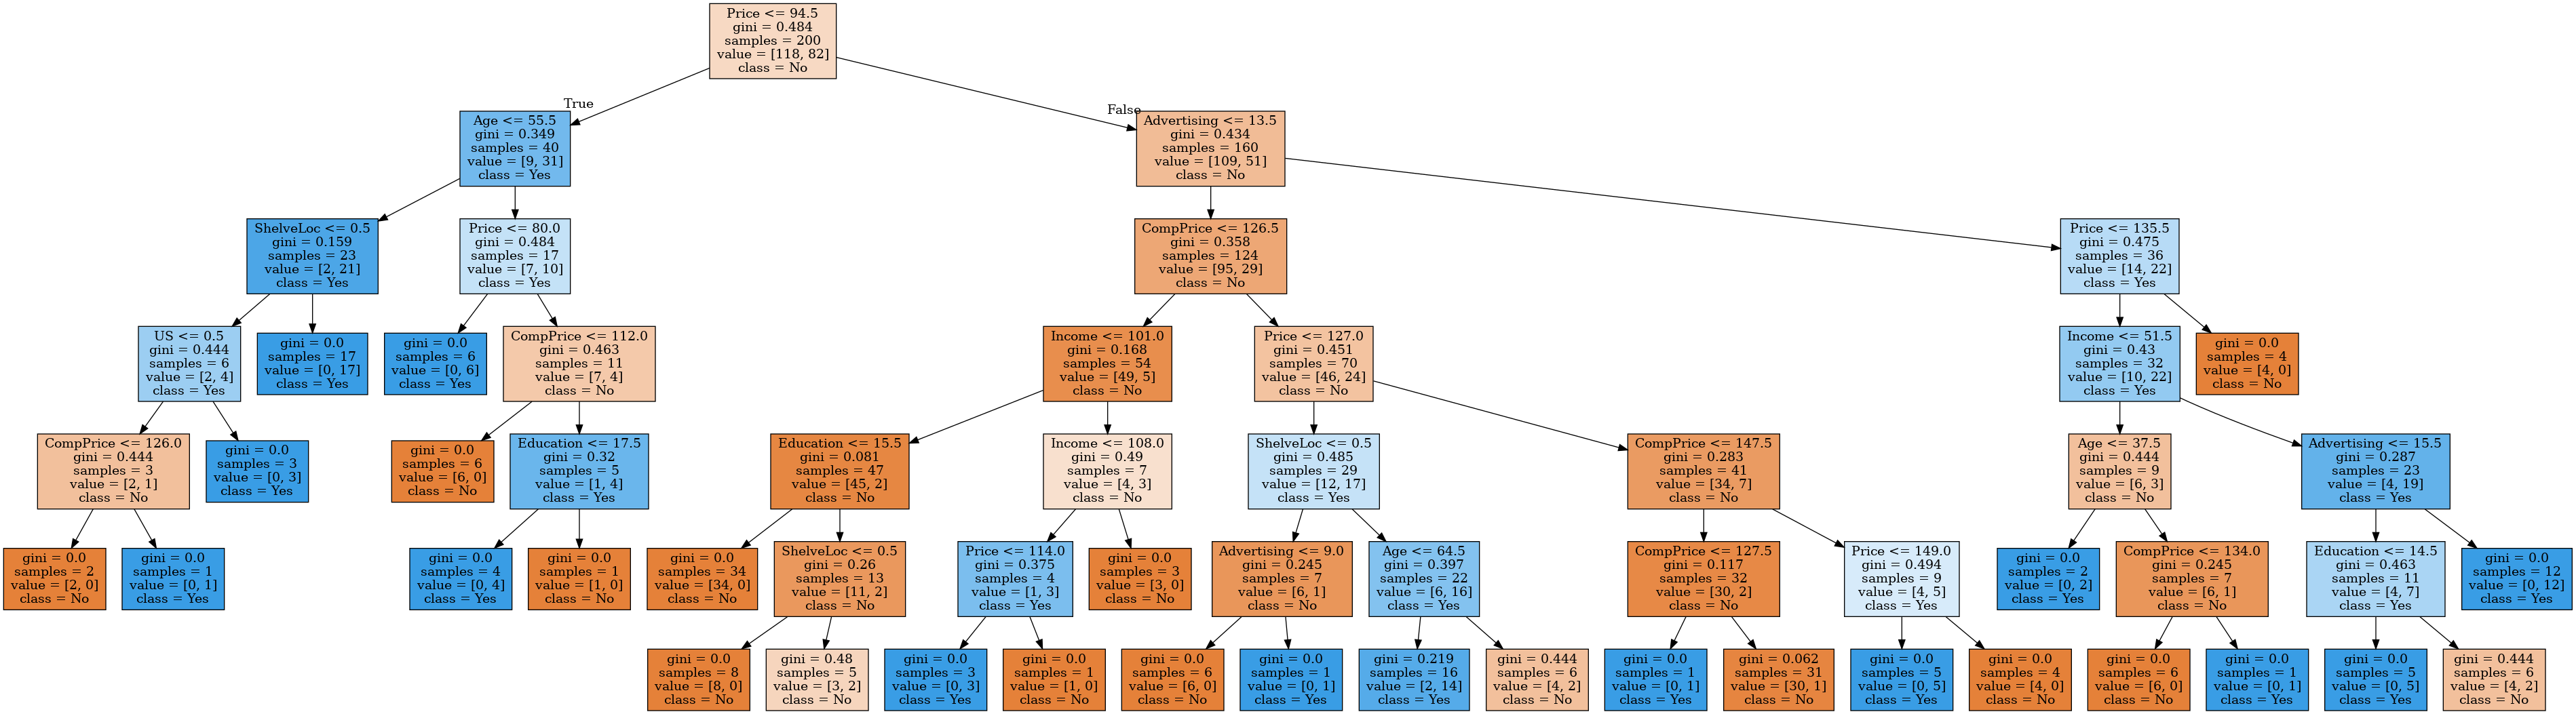

In [11]:
graph = print_tree(clf_gini, features=X_train.columns, class_names=['No', 'Yes'])
Image(graph.create_png())

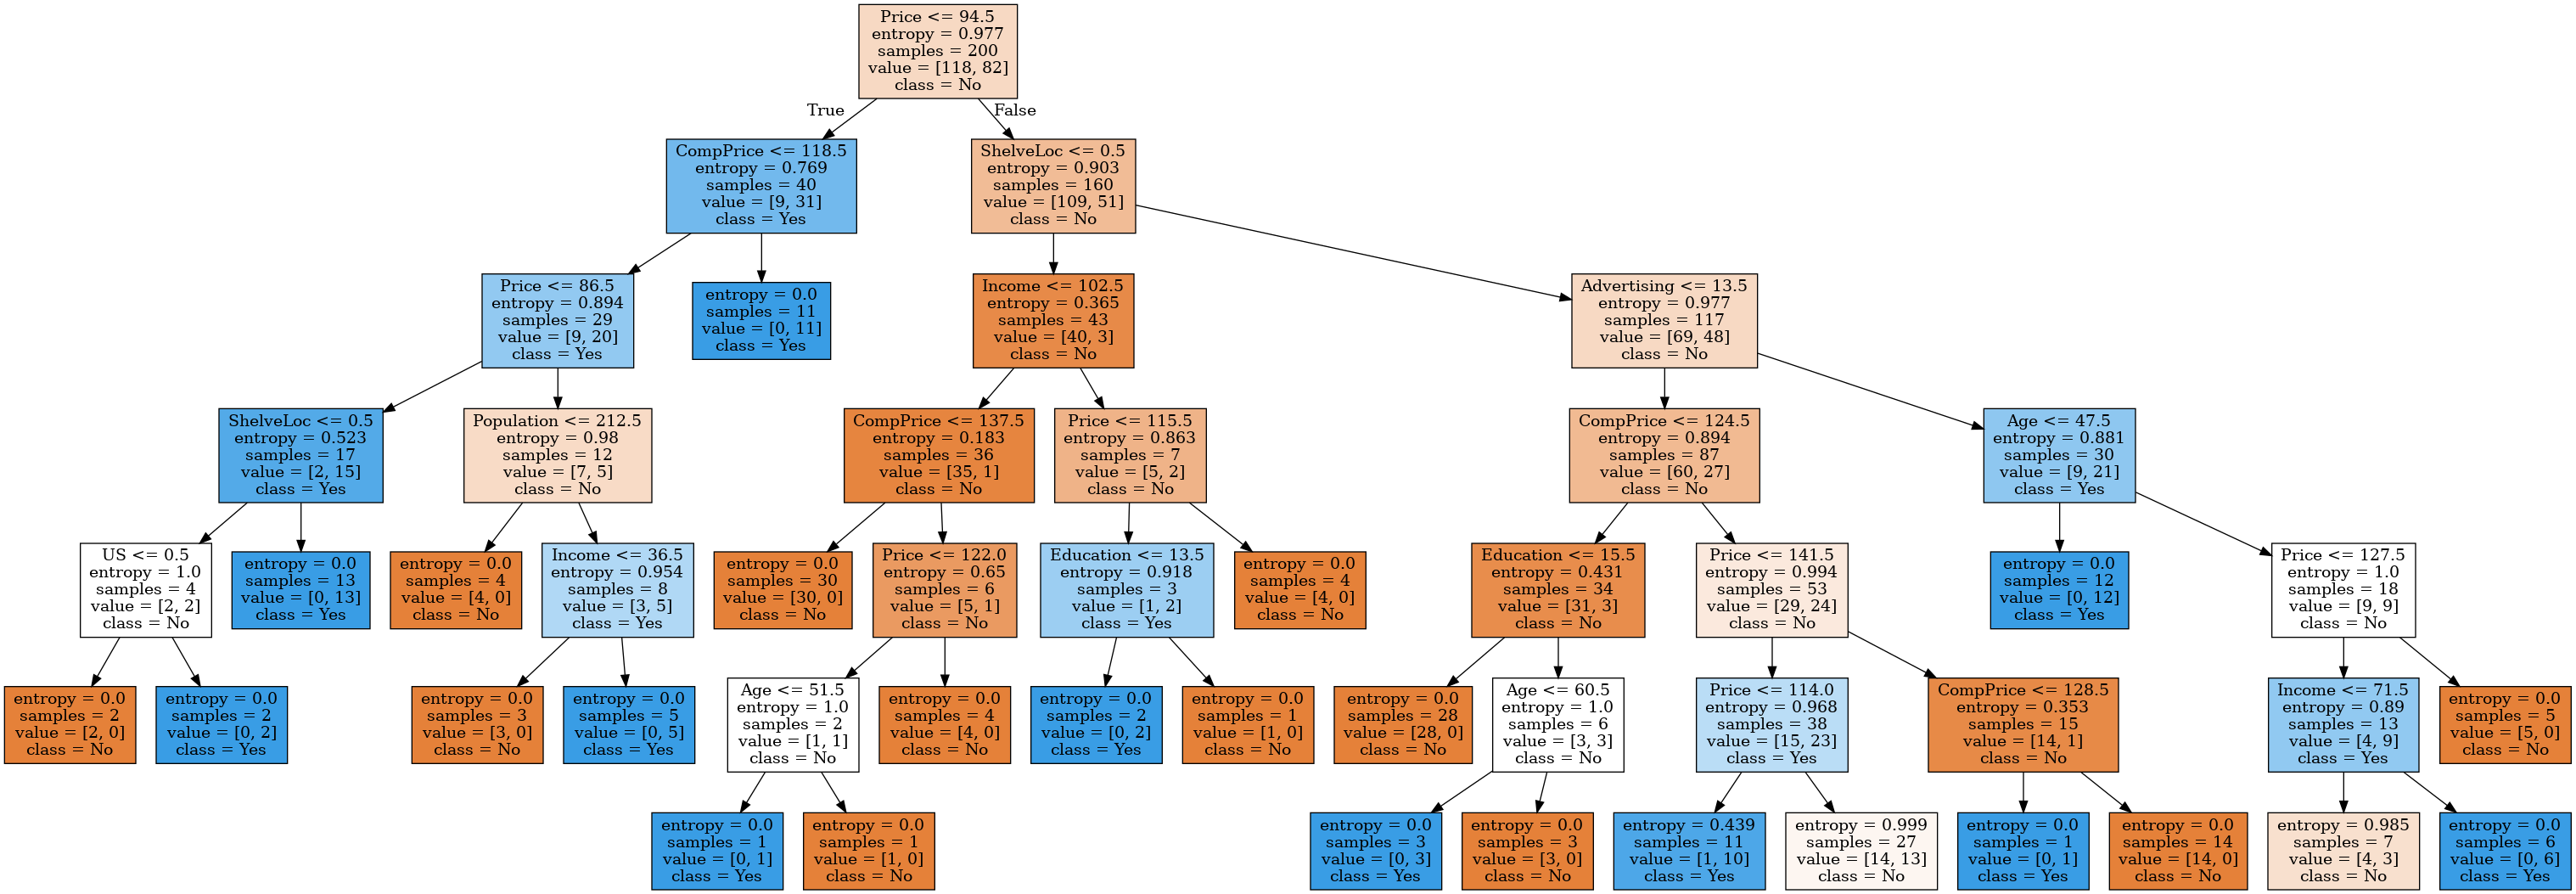

In [12]:
graph = print_tree(clf_entropy, features=X_train.columns, class_names=['No', 'Yes'])
Image(graph.create_png())

In [13]:
pred_gini = clf_gini.predict(X_test)
pred_entropy = clf_entropy.predict(X_test)

In [14]:
# Precision of the model using test data is 75%
print(classification_report(y_test, pred_gini))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       118
           1       0.73      0.62      0.67        82

    accuracy                           0.75       200
   macro avg       0.75      0.73      0.73       200
weighted avg       0.75      0.75      0.75       200



In [15]:
# Precision of the model using test data is 73%
print(classification_report(y_test, pred_entropy))

              precision    recall  f1-score   support

           0       0.71      0.85      0.78       118
           1       0.70      0.51      0.59        82

    accuracy                           0.71       200
   macro avg       0.71      0.68      0.68       200
weighted avg       0.71      0.71      0.70       200



<h2>Choosing Hyperparameters</h2>

In [16]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score

# Specify cross-validation generator, in this case (10 x 5CV)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10,random_state=42)

param_grid = [
    {'criterion': ['gini','entropy'], 'max_depth': range(2, 10)}
]

scoring = make_scorer(precision_score,greater_is_better=True)
g_cv = GridSearchCV(DecisionTreeClassifier(random_state=42),
              param_grid=param_grid,
              scoring=scoring, cv=cv,n_jobs=-1)

g_cv.fit(X_train,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=42),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': range(2, 10)}],
             scoring=make_scorer(precision_score))

In [17]:
results_df = pd.DataFrame(g_cv.cv_results_)
results_df = results_df.sort_values(by=['rank_test_score'])
results_df = (
    results_df
    .set_index(results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('params')
)
results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
params,,,,
entropy_6,"{'criterion': 'entropy', 'max_depth': 6}",1,0.658012,0.081458
entropy_7,"{'criterion': 'entropy', 'max_depth': 7}",2,0.656835,0.106593
entropy_2,"{'criterion': 'entropy', 'max_depth': 2}",3,0.656687,0.207750
entropy_9,"{'criterion': 'entropy', 'max_depth': 9}",4,0.640957,0.082795
entropy_4,"{'criterion': 'entropy', 'max_depth': 4}",5,0.635165,0.113336
gini_4,"{'criterion': 'gini', 'max_depth': 4}",6,0.630637,0.090895
gini_2,"{'criterion': 'gini', 'max_depth': 2}",7,0.628033,0.171653
entropy_8,"{'criterion': 'entropy', 'max_depth': 8}",8,0.626251,0.077623
gini_6,"{'criterion': 'gini', 'max_depth': 6}",9,0.623515,0.078226


In [18]:
precision_score(y_test, g_cv.best_estimator_.predict(X_test))

0.6875